In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bayesian_pdes
import sympy as sp
%matplotlib inline

In [2]:
ni = 18
nb = 9

In [69]:
x_1,x_2,y_1,y_2 = sp.symbols('x_1 x_2 y_1 y_2')
length_scale = 0.05
k = sp.exp(-((x_1-y_1)**2+(x_2-y_2)**2) / (2*length_scale**2))
A = lambda f: sp.diff(f, x_1, x_1) + sp.diff(f, x_2, x_2)
Abar = lambda f: sp.diff(f, y_1, y_1) + sp.diff(f, y_2, y_2)
B = lambda f: f
Bbar = lambda f: f
symbols = [[x_1, x_2], [y_1, y_2]]

# interior observations: sin(x)*sin(y)
x_interior, y_interior = np.mgrid[0.1:0.9:ni*1j, 0.1:0.9:ni*1j]
interior = np.c_[x_interior.ravel(), y_interior.ravel()]
exterior = np.r_[
    np.c_[np.linspace(0.1,0.9,nb), np.zeros(nb)], 
    np.c_[np.linspace(0.1,0.9,nb), np.ones(nb)],
    np.c_[np.zeros(nb), np.linspace(0.1,0.9,nb)],
    np.c_[np.ones(nb), np.linspace(0.1,0.9,nb)]
]

interior_obs = np.sin(2*np.pi*interior[:,0]) + np.sin(2*np.pi*interior[:,1])
exterior_obs = np.r_[
    np.zeros(nb*2),
    np.zeros(nb*2)
]

print interior.shape, interior_obs.shape
print exterior.shape, exterior_obs.shape
posterior = bayesian_pdes.collocate([A, B], [Abar, Bbar], k, symbols, [(interior, interior_obs), (exterior, exterior_obs)])

(324, 2) (324,)
(36, 2) (36,)


<matplotlib.colorbar.Colorbar instance at 0x7ff557bc2710>

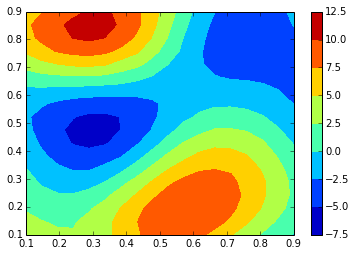

In [4]:
mean, cov = posterior(interior)
samp = np.random.multivariate_normal(mean, cov, 1)
plt.colorbar(plt.contourf(x_interior, y_interior, samp.reshape(x_interior.shape)))

In [5]:

def substitute(operators, dic):
    """
    Given an array of operator functionals, compose with the substitution functional specified by dic and return
    a new functional.
    """
    def __subs_op(o, dic):
        return lambda f: o(f).subs(dic)
    return [__subs_op(o, dic) for o in operators]


In [55]:
# set up the Allen-Cahn system
#d = sp.Symbol('delta')
d = 0.04
A_1 = lambda f: -d*(sp.diff(f, x_1, x_1) + sp.diff(f, x_2, x_2)) - 1./d * f
A_1_bar = lambda f: -d*(sp.diff(f, y_1, y_1) + sp.diff(f, y_2, y_2)) - 1./d * f
Identity = lambda f: f
B = Identity

ops = [A_1, Identity, B]
ops_bar = [A_1_bar, Identity, B]

# for now collocate on a basic grid (this is not efficient)
x, y = np.mgrid[0:1:21j, 0:1:21j]
x = x.ravel(); y = y.ravel()

on_bdy = (x == 0.) | (x == 1.) | (y == 0.) | (y == 1.)

collocate_interior = np.c_[x[~on_bdy], y[~on_bdy]]

collocate_boundary = np.c_[x[on_bdy], y[on_bdy]]

# define what the RHS of the system looks like
def rhs(locations):
    return np.zeros(location.shape[0])

# and on the boundary...
def boundary_rhs(locations):
    ret = np.empty(locations.shape[0])
    # impose condition on the y boundary
    y_bdy = (locations[:,1] == 1) | (locations[:,1] == 0)
    ret[y_bdy] = -1
    # impose condition on the x boundary
    x_bdy = (locations[:,0] == 1) | (locations[:,0] == 0)
    ret[x_bdy] = 1
    
    if np.any(~(x_bdy | y_bdy)):
        missing = locations[~(x_bdy | y_bdy), :]
        raise Exception("Some boundary observations don't appear to be on the boundary: {}".format(missing))
    return ret

boundary_obs = boundary_rhs(collocate_boundary)

In [56]:
def cube_root(arr):
    arr = np.asarray(arr)
    ret = np.empty_like(arr)
    ret[arr >= 0] = arr[arr > 0]**(1./3)
    ret[arr < 0] = - np.abs(arr[arr < 0])**(1./3)
    return ret

# Calculation of Importance Distn

In [57]:
from deflation.deflation import ForwardProblem
from deflation.petscsnessolver import PetscSnesSolver
import dolfin
from dolfin import dx
import math
import logging
logging.getLogger('FFC').setLevel(logging.WARNING)

In [58]:
# for ipython notebook
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.tri as tri

def mesh2triang(mesh):
    xy = mesh.coordinates()
    return tri.Triangulation(xy[:, 0], xy[:, 1], mesh.cells())

def plot(obj):
    plt.gca().set_aspect('equal')
    if isinstance(obj, dolfin.Function):
        mesh = obj.function_space().mesh()
        if (mesh.geometry().dim() != 2):
            raise(AttributeError)
        if obj.vector().size() == mesh.num_cells():
            C = obj.vector().array()
            plt.tripcolor(mesh2triang(mesh), C)
        else:
            C = obj.compute_vertex_values(mesh)
            plt.tripcolor(mesh2triang(mesh), C, shading='gouraud')
    elif isinstance(obj, dolfin.Mesh):
        if (obj.geometry().dim() != 2):
            raise(AttributeError)
        plt.triplot(mesh2triang(obj), color='k')


In [59]:
import sys
args = [sys.argv[0]] + """
                       --petsc.snes_max_it 200
                       --petsc.snes_monitor
                       --petsc.snes_converged_reason
                       --petsc.snes_stol 0.0
                       --petsc.snes_rtol 0.0
                       --petsc.snes_type newtonls
                       --petsc.snes_linesearch_type basic

                       --petsc.ksp_type gmres
                       --petsc.ksp_rtol 1.0e-12
                       --petsc.ksp_atol 1.0e-12

                       --petsc.inner_pc_type lu
                       """.split()
dolfin.parameters.parse(argv=args)

In [60]:
def find_solutions(delta, mesh_points, plot_solutions=False):
    mesh = dolfin.UnitSquareMesh(mesh_points, mesh_points)
    size = dolfin.MPI.size(dolfin.mpi_comm_world())
    if size > 1:
        nrefine = math.log(size, 4)
        if int(nrefine) != nrefine:
            print "Need to have processors a power of 4, as each refinement multiplies work by 4"
            assert False

        for i in range(int(nrefine) + 3):
            mesh = dolfin.refine(mesh, redistribute=False)

    V = dolfin.FunctionSpace(mesh, "CG", 1)
    Vdim = V.dim()
    if dolfin.MPI.rank(dolfin.mpi_comm_world()) == 0:
            print "Degrees of freedom: ", Vdim
            print "Degrees of freedom per core: ", Vdim/float(size)

    delta = dolfin.Constant(0.04)

    u = dolfin.Function(V)

    v = dolfin.TestFunction(V)
    F = delta * dolfin.inner(dolfin.grad(v), dolfin.grad(u))*dx + 1.0/delta * dolfin.inner(v, u**3 - u)*dx

    bcs = [dolfin.DirichletBC(V, +1.0, "x[0] == 0.0 || x[0] == 1"),
           dolfin.DirichletBC(V, -1.0, "x[1] == 0.0 || x[1] == 1")]

    power = 1
    shift = 0.1
    problem = ForwardProblem(F, V, u, bcs, power=power, shift=shift)
    solver = PetscSnesSolver()

    roots = []
    natol = 1.0e-8

    for i in range(3):
        dolfin.PETScOptions.set("snes_atol", natol)
        solver.solve(problem, u.vector())
        roots.append(dolfin.Function(u, name="Solution"))

        if plot:
            plt.figure()
            plot(roots[-1])
            plt.colorbar()
            plt.show()

        u.assign(dolfin.Constant(0))
        problem.deflate(roots[-1])
        if shift > 0:
            natol *= shift
    return roots, V

In [61]:
def compute_latent(points, delta, solutions):
    # it is most convenient to compute the latent variables as the cube of the values at the points (i.e. at A_2),
    # since this means we don't have to fuss about with gradients.
    res = np.empty((points.shape[0], len(solutions)))
    for i in range(len(solutions)):
        res[:,i] = np.vectorize(solutions[i])(points[:,0], points[:,1])
    return -res**3 / delta

Degrees of freedom:  10201
Degrees of freedom per core:  10201.0


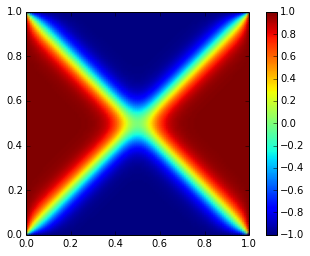

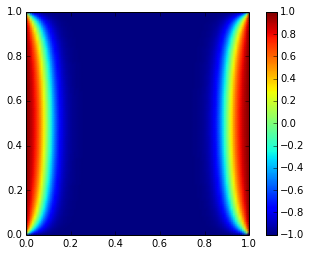

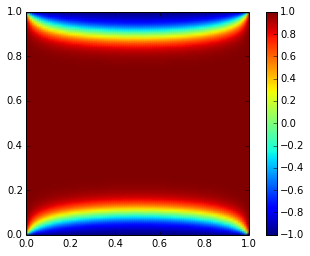

In [62]:
solutions, f_space = find_solutions(0.04, 100, plot_solutions=True)

In [63]:
z = compute_latent(collocate_interior, 0.04, solutions)

# Calculation of PN Probability

In [70]:
def p_pn(true_obs, delta, z, sigma, debug=False):
    """
    true_obs: Tuple of observation locations and observation values for the true solution u
    delta: The current value of the parameter delta
    z: The current value of the latent variable z
    sigma: Allowed observation error in the Gaussian likelihood.
    returns: The PN probability p(y | delta)
    """
    true_locations, y = true_obs
    
    obs = [
        (collocate_interior, z),
        (collocate_interior, cube_root(-delta*z)),
        (collocate_boundary, boundary_obs)
    ]
    
    #ops_subs = substitute(ops, {d: delta})
    #ops_bar_subs = substitute(ops_bar, {d: delta})
    ops_subs = ops
    ops_bar_subs = ops_bar
    
    posterior = bayesian_pdes.collocate(ops_subs, ops_bar_subs, k, symbols, obs)
    mu, Sigma = posterior(true_locations)
    if debug:
        size = int(np.sqrt(true_locations.shape[0]))
        shape = (size, size)
        plt.figure(figsize=(10,10))
        plt.contourf(true_locations[:,0].reshape(shape), true_locations[:,1].reshape(shape), mu.reshape(shape))
        plt.colorbar()
        
        plt.figure(figsize=(10,10))
        plt.colorbar(plt.imshow(Sigma, interpolation=None))
        plt.show()
        
    
    error_mat = np.eye(mu.shape[0])*sigma**2
    Sigma_plus_error = Sigma + error_mat
    Sigma_plus_error_inv = np.linalg.inv(Sigma_plus_error)
    exponent = -0.5 * (y - mu).T.dot(Sigma_plus_error_inv).dot(y - mu)
    fractional = np.linalg.det(2*np.pi*Sigma_plus_error)
    
    if debug:
        print 'True | Mean'
        print np.c_[y, mu]
        print 'Average abs. error: {}'.format(np.mean(np.abs(y-mu)))
        print 'Exponent: {} Fractional: {}'.format(exponent, fractional)
    
    return 1./np.sqrt(fractional) * np.exp(exponent)

In [71]:
tmp = np.vectorize(solutions[0])(collocate_interior[:,0], collocate_interior[:,1])
true_obs = (collocate_interior, tmp)

In [72]:
true_locations, y = true_obs
    
obs = [
    (collocate_interior, z[:,0]),
    (collocate_interior, cube_root(-0.04*z[:,0])),
    (collocate_boundary, boundary_obs)
]
posterior = bayesian_pdes.collocate(ops, ops_bar, k, symbols, obs)

In [73]:
posterior(np.array([[0.1, 0.1]]))

(array([ -3.80173953e-05]), array([[ -6.67910172e-13]]))

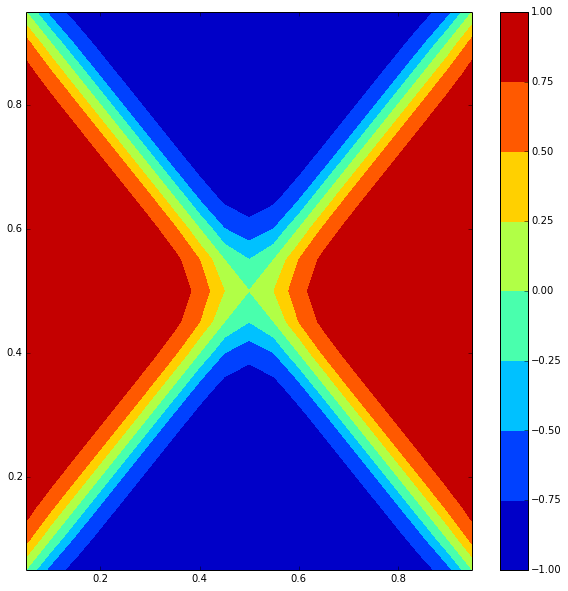

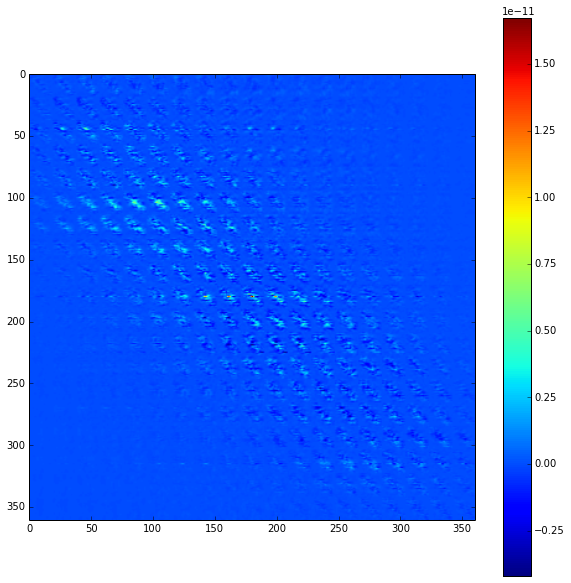

True | Mean
[[ -6.42168173e-05  -6.42168170e-05]
 [  6.02676948e-01   6.02676948e-01]
 [  8.66412052e-01   8.66412052e-01]
 [  9.59083516e-01   9.59083516e-01]
 [  9.87970869e-01   9.87970869e-01]
 [  9.96521809e-01   9.96521809e-01]
 [  9.99000600e-01   9.99000600e-01]
 [  9.99712059e-01   9.99712059e-01]
 [  9.99911864e-01   9.99911864e-01]
 [  9.99954927e-01   9.99954927e-01]
 [  9.99917334e-01   9.99917334e-01]
 [  9.99729719e-01   9.99729719e-01]
 [  9.99050245e-01   9.99050245e-01]
 [  9.96650069e-01   9.96650069e-01]
 [  9.88259011e-01   9.88259011e-01]
 [  9.59554144e-01   9.59554144e-01]
 [  8.66584034e-01   8.66584034e-01]
 [  6.01528727e-01   6.01528727e-01]
 [  1.13819670e-07   1.13820717e-07]
 [ -6.02732570e-01  -6.02732570e-01]
 [ -3.80173956e-05  -3.80173960e-05]
 [  5.60555538e-01   5.60555538e-01]
 [  8.50677144e-01   8.50677144e-01]
 [  9.54783031e-01   9.54783031e-01]
 [  9.86841250e-01   9.86841250e-01]
 [  9.96216157e-01   9.96216157e-01]
 [  9.98909608e-01   9.989

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:48: RuntimeWarning: divide by zero encountered in double_scalars


inf

In [74]:
p_pn(true_obs, 0.04, z[:,0], 0.1, debug=True)